In [8]:
import re
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

plt.rcParams['figure.facecolor'] = 'white'
pd.options.display.max_colwidth = None

orig_df = pd.read_csv('responses.csv')
orig_df['Timestamp'] = pd.to_datetime(orig_df['Timestamp'])

def explodeColumn(df, column_name, prefix=None):
    if prefix is None:
        prefix = column_name
    return df[column_name].fillna('').str.split(',\s*').apply(lambda x: pd.Series(1,index=x)).fillna(0).drop("", axis=1, errors='ignore').add_prefix(prefix + ': ')

def getHighestStep(num):
    for i in [0, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150][::-1]:
        if i < num:
            return i
    return 0

def zeroUntilFirstTrue(df):
    for col in df.columns:
        if col in ["Trigger: Incubus", "Trigger: Demon", "Pre-TG: Incubus", "Post-TG: Blonde", "Post-TG: Brunette", "Post-TG: Redhead"]:
            first_true = 155
        elif col in ["Website: 8muses", "Website: NexxusHost.com", "Website: Overflowing Bra", "Website: Nifty Erotic Stories Archive", "Trigger: Gadget", "Trigger: Sci-Fi", "Trigger: Splitting", "Trigger: Multiple Changes", "Post-TG: Haircut", "Scenario: Getting a haircut", "Scenario: Hiding changes", "Post-TG: Lolita", "Post-TG: Petticoats", "Post-TG: Secretary", "Post-TG: Rubber / Leather / Latex", "Post-TG: Gender Identity Exploration / Readjustment", "Post-TG: Shaving", "Partner: Another TGee (Opposite TG)"]:
            first_true = 156
        elif col in ["Sex: Females Only", "Sex: Body Exploration (Sexual)", "Partner: Husband", "Partner: Wife", "Partner: Mugger / Robber / Thief", "Scenario: Bad End", "Scenario: Yuri", "Trigger Feature: Punishment", "Trigger Feature: Obligation", "Environment: Bedroom", "Scenario: Trying on Clothes", "Role: Partner (you are the the TGee's partner)", "Sex: Watersports / Urination"]:
            first_true = 157
        elif col in ["Creator (the TGee is your creation)", "Awkward interactions with friends"]:
            first_true = 158
        else:
            first_true = getHighestStep(df[col].idxmax())
        
        df[col].values[0:first_true] = None
    return df

def dropAndMerge(df1, df2, column_name):
    return df1.merge(df2, left_index=True, right_index=True).drop(column_name, axis=1)

def extractNum(string):
    if string is None:
        return None
    r = re.search(r'\d+', str(string))
    if r is None:
        return None
    return int(r.group())

# sanitize columns
column = "Are you a TG fan?"
df = explodeColumn(orig_df, column, 'TG Fan')
df = zeroUntilFirstTrue(df)
orig_df = dropAndMerge(orig_df, df, column)

column = "Do you consider yourself a part of any of the following fandoms?"
df = explodeColumn(orig_df, column, 'Fandom')
df = zeroUntilFirstTrue(df)
orig_df = dropAndMerge(orig_df, df, column)

column = "If you are not any of the above or would like to add more, what would you consider yourself a part of (related to TG)?"
orig_df = orig_df.drop(column, axis=1)

column = "If you are a FURRY, did you enter that fandom before or after you discovered an interest in TG? If you are not or if your interest in furry is unrelated to TG, please skip this question."
orig_df = orig_df.drop(column, axis=1)

column = "What gender do you define yourself as in real life? (Check all that apply)"
df = explodeColumn(orig_df, column, 'Gender IRL')
df = df[["Gender IRL: Male", "Gender IRL: Female", "Gender IRL: Transgender (MtF)", "Gender IRL: Transgender (FtM)", "Gender IRL: Non-binary", "Gender IRL: Genderfluid", "Gender IRL: Unsure", "Gender IRL: Prefer not to share"]]
df["Gender IRL: Male"] = df.apply(lambda x: 1.0 if x["Gender IRL: Male"] or x["Gender IRL: Transgender (FtM)"] else 0.0, axis=1)
df["Gender IRL: Female"] = df.apply(lambda x: 1.0 if x["Gender IRL: Female"] or x["Gender IRL: Transgender (MtF)"] else 0.0, axis=1)
orig_df = dropAndMerge(orig_df, df, column)

column = "What is your sexuality regarding real life attractions? (Spectrum / Binary)"
orig_df["Sexuality IRL"] = orig_df[column].apply(extractNum)
orig_df.drop(column, axis=1)

column = "What gender do you define yourself regarding TG scenarios and fantasies? (Check all that apply)"
df = explodeColumn(orig_df, column, 'Gender TG')
df = df[["Gender TG: Male", "Gender TG: Female", "Gender TG: Transgender (MtF)", "Gender TG: Transgender (FtM)", "Gender TG: Non-binary", "Gender TG: Genderfluid", "Gender TG: Unsure", "Gender TG: Prefer not to share"]]
df["Gender TG: Male"] = df.apply(lambda x: 1.0 if x["Gender TG: Male"] or x["Gender TG: Transgender (FtM)"] else 0.0, axis=1)
df["Gender TG: Female"] = df.apply(lambda x: 1.0 if x["Gender TG: Female"] or x["Gender TG: Transgender (MtF)"] else 0.0, axis=1)
orig_df = dropAndMerge(orig_df, df, column)

column = "What is your sexuality regarding TG scenarios and fantasies? (Spectrum / Binary)"
orig_df["Sexuality TG"] = orig_df[column].apply(extractNum)
orig_df.drop(column, axis=1)

column = "What media or artistic formats do you find an interest in or follow (in regards to TG)?"
df = explodeColumn(orig_df, column, 'Media')
df = zeroUntilFirstTrue(df)
orig_df = dropAndMerge(orig_df, df, column)

column = "If the media formats above do not contain one or more of what you were looking for, please add it in the space below."
orig_df = orig_df.drop(column, axis=1)

column = "What WEBSITES do you consider influential or contributing to your interest in TG?"
df = explodeColumn(orig_df, column, 'Website')
df = zeroUntilFirstTrue(df)
orig_df = dropAndMerge(orig_df, df, column)

column = "What TG TRIGGERS OR MECHANISMS do you enjoy?"
df = explodeColumn(orig_df, column, 'Trigger')
df["Trigger: Body Part Size / Modification / Detachable / Attachable"] = df.apply(lambda x: 1.0 if x["Trigger: Body Part Size / Modification / Detachable / Attachable"] or x["Trigger: Body Part Size / Modification / Detachable"] else 0.0, axis=1)
df = df.drop("Trigger: Body Part Size / Modification / Detachable", axis=1)
carryover = df["Trigger: Involuntary"]
df = df.drop("Trigger: Involuntary", axis=1)
df = zeroUntilFirstTrue(df)
orig_df = dropAndMerge(orig_df, df, column)

column = "What SUPPLEMENTARY FEATURES of TG do you enjoy?"
df = explodeColumn(orig_df, column, 'Trigger Feature')
df["Trigger Feature: Hair Length Change"] = df.apply(lambda x: 1.0 if x["Trigger Feature: Hair Length Change"] or x["Trigger Feature: Hair Change"] else 0.0, axis=1)
df["Trigger Feature: Hair Color Change"] = df.apply(lambda x: 1.0 if x["Trigger Feature: Hair Color Change"] or x["Trigger Feature: Hair Change"] else 0.0, axis=1)
df["Trigger Feature: Involuntary"] = df.apply(lambda x: 1.0 if x["Trigger Feature: Involuntary"] or carryover[x.name] else 0.0, axis=1)
df = df.drop("Trigger Feature: Hair Change", axis=1)
df = zeroUntilFirstTrue(df)
orig_df = dropAndMerge(orig_df, df, column)

column = "If your desired TRIGGER OR MECHANISM selection was not included, what would you add to this list? Fill in the blank below."
orig_df = orig_df.drop(column, axis=1)

column = "If your desired SUPPLEMENTARY FEATURE was not included, what would you add to this list? Fill in the blank below."
orig_df = orig_df.drop(column, axis=1)

column = "What EMOTIONS in TG do you enjoy viewing? (in relation to the TGee)"
df = explodeColumn(orig_df, column, 'Emotion')
orig_df = dropAndMerge(orig_df, df, column)

column = "If your desired EMOTION was not included, what would you add to this list? Fill in the blank below."
orig_df = orig_df.drop(column, axis=1)

column = "What PRE-TG FEATURES do you enjoy viewing (in relation to the TGee)?"
df = explodeColumn(orig_df, column, 'Pre-TG')
df = zeroUntilFirstTrue(df)
orig_df = dropAndMerge(orig_df, df, column)

column = "What POST-TG FEATURES do you enjoy viewing (in relation to the TGee)?"
df = explodeColumn(orig_df, column, 'Post-TG')
df["Post-TG: Guro / Gore"] = df.apply(lambda x: 1.0 if x["Post-TG: Guro / Gore"] or x["Post-TG: Guro"] else 0.0, axis=1)
df = df.drop("Post-TG: Guro", axis=1)
df = df.drop("Post-TG: Exhibitionism (Willing)", axis=1)
df = zeroUntilFirstTrue(df)
orig_df = dropAndMerge(orig_df, df, column)

column = "If your desired PRE-TG FEATURE was not included, what would you add to this list? Fill in the blank below."
orig_df = orig_df.drop(column, axis=1)

column = "If your desired POST-TG FEATURE was not included, what would you add to this list? Fill in the blank below."
orig_df = orig_df.drop(column, axis=1)

column = "What SEX-RELATED FEATURES do you enjoy viewing (post TG, in relation to the TGee)?"
df = explodeColumn(orig_df, column, 'Sex')
df = zeroUntilFirstTrue(df)
orig_df = dropAndMerge(orig_df, df, column)

column = "If your desired SEX-RELATED FEATURE was not included, what would you add to this list? Fill in the blank below."
orig_df = orig_df.drop(column, axis=1)

column = "What ENVIRONMENTS do you enjoy viewing (related to TG media)?"
df = explodeColumn(orig_df, column, 'Environment')
df = zeroUntilFirstTrue(df)
orig_df = dropAndMerge(orig_df, df, column)

column = "If your desired ENVIRONMENT was not included, what would you add to this list? Fill in the blank below."
orig_df = orig_df.drop(column, axis=1)

column = "What TG PARTNERS do you enjoy viewing (in relation to TGee)?"
df = explodeColumn(orig_df, column, 'Partner')
df = zeroUntilFirstTrue(df)
orig_df = dropAndMerge(orig_df, df, column)

column = "If your desired PARTNER was not included, what would you add to this list? Fill in the blank below."
orig_df = orig_df.drop(column, axis=1)

column = "What ROLES in TG do you enjoy imagining yourself in?"
df = explodeColumn(orig_df, column, 'Role')
orig_df = dropAndMerge(orig_df, df, column)

column = "Where did you hear about this survey?"
df = explodeColumn(orig_df, column, 'From')
df["From: Patreon"] = df.apply(lambda x: 1.0 if x["From: Patreon"] or 'patreon' in orig_df["If your desired referral was not included, what would you add to this list? Fill in the blank below."].fillna('')[x.name].lower() else 0.0, axis=1)
orig_df = dropAndMerge(orig_df, df, column)

column = "If your desired referral was not included, what would you add to this list? Fill in the blank below."
orig_df = orig_df.drop(column, axis=1)

column = "Do you have any FEEDBACK for this survey to improve, or questions you would like to see asked? Fill out the space below."
orig_df = orig_df.drop(column, axis=1)

column = "Do you consider yourself a content creator?"
orig_df = orig_df.drop(column, axis=1)

column = "What SCENARIOS OR THEMES do you enjoy viewing (related to TG media)?"
df = explodeColumn(orig_df, column, 'Scenario')
df = zeroUntilFirstTrue(df)
orig_df = dropAndMerge(orig_df, df, column)

column = "If your desired SCENARIO OR THEME was not included, what would you add to this list? Fill in the blank below."
orig_df = orig_df.drop(column, axis=1)

column = "Email Address"
orig_df = orig_df.drop(column, axis=1)

column = "Feel free to type anything else you want into this box and I'll read it. -espeon"
orig_df = orig_df.drop(column, axis=1)

column = "What do you dislike about current TG media? Is there something that, if you encounter it, you will stop consuming the work? Is there something you exclusively seek out as a requirement?"
orig_df = orig_df.drop(column, axis=1)

column = "What do you like/dislike about the online TG community? What do you wish would change about the online TG community?"
orig_df = orig_df.drop(column, axis=1)

column = "If you had $1000 to spend on TG-related things, what would you spend it on?"
orig_df = orig_df.drop(column, axis=1)

column = "How extreme do you consider your sex preferences (in relation to TG)?"
orig_df = orig_df.drop(column, axis=1)

column = "If your desired ROLE was not included, what would you add to this list? Fill in the blank below."
orig_df = orig_df.drop(column, axis=1)


KeyError: 'Trigger: Permanent / Irreversible'

In [ ]:
# Sanitization here
bool_df = orig_df[[x for x in orig_df.columns if ":" in x]]

last_true = bool_df.apply(lambda x: x[::-1].idxmax())
df = bool_df.apply(lambda x: x.value_counts()).transpose()

total = len(orig_df)

df["Total"] = df[1.0] + df[0.0]
df["LastTrue"] = last_true
df["Decay"] = total - df["LastTrue"]
df["Percent"] = df[1.0] / df["Total"] * 100
df = df.sort_values(by="Percent")
df = df.drop("", errors="ignore")

# print(df.loc['Trigger: Involuntary'])
# print(df.loc['TG Fan: Yes'])
df = df.query("Total < 20 or `1.0` < 5 or Decay > 240")
# df = df.query("True")
# print(df)

for col in df.index:
#     print(col)
    orig_df = orig_df.drop(col, axis=1)



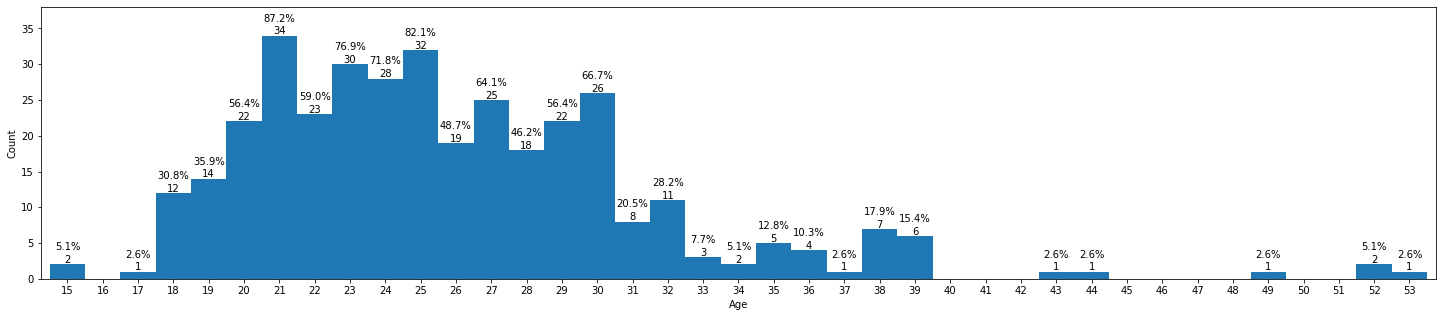

In [4]:
# AGE
df = orig_df.groupby(by=["What is your age?"]).size()

mn = int(df.index.min())
mx = int(df.index.max()) + 1

df = df.reindex(np.arange(mn, mx)).fillna(0).astype(int)

ax = df.plot(kind="bar", figsize=(25, 5), width=1, rot=0)

ax.set_ylabel("Count")
ax.set_xlabel("Age")

ax.set_ylim(0, df.max() + 4)

for p in ax.patches:
    if p.get_height() != 0:
        ax.annotate("{:.0f}".format(p.get_height()), (p.get_x() + 0.5, p.get_height() + 0.2), ha="center")
        ax.annotate("{:.1f}%".format(p.get_height() / len(df) * 100), (p.get_x() + 0.5, p.get_height() + 2), ha="center")

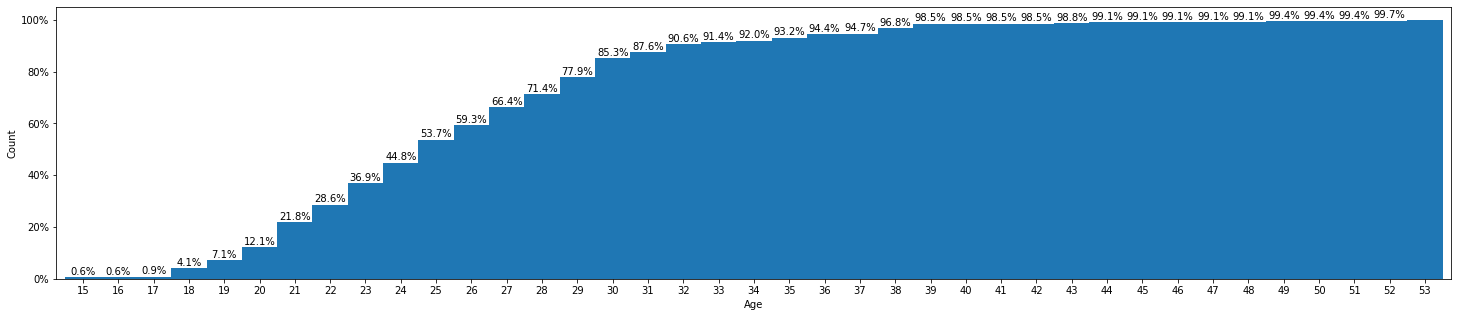

In [612]:
# AGE
df = orig_df.groupby(by=["What is your age?"]).size()

mn = int(df.index.min())
mx = int(df.index.max()) + 1

df = df.reindex(np.arange(mn, mx)).fillna(0).astype(int)

df = df.cumsum() / df.sum() * 100

ax = df.plot(kind="bar", figsize=(25, 5), width=1, rot=0)

ax.set_ylabel("Count")
ax.set_xlabel("Age")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

for p in ax.patches:
    if p.get_height() != 0 and p.get_height() != 100:
        ax.annotate("{:.1f}%".format(p.get_height()), (p.get_x() + 0.5, p.get_height() + 1), ha="center")
#         ax.annotate("{:.1f}%".format(p.get_height() / len(df) * 100), (p.get_x() + 0.5, p.get_height() + 2), ha="center")

In [249]:
df = orig_df["What is your age?"].describe()
df

count    339.000000
mean      26.014749
std        5.613521
min       15.000000
25%       22.000000
50%       25.000000
75%       29.000000
max       53.000000
Name: What is your age?, dtype: float64

In [ ]:
frequent_itemsets.sort_values(['length', 'support'], ascending=False)

In [ ]:
# pd.options.display.max_rows = None
# rules[rules["antecedent_length"] >= 3]
rules[(rules["antecedent_length"] == 1) & (rules["consequent_length"] == 1)].sort_values(by="lift", ascending=False)[['antecedents', 'consequents', 'support', 'confidence', 'lift']][0:30]


In [339]:
columns_describe = [x for x in orig_df.columns if ":" not in x]
orig_df[columns_describe].describe().transpose().rename({
    "What is your age?": "Age Now",
    "What age did you discover an interest in TG?": "Age Discover",
    "What age did you begin to explore TG online?": "Age Online",
    "What year did you discover an interest in TG?": "Year Discover",
    "What year did you begin to explore TG online?": "Year Online",
    "What proportion of sex-to-non-sex ratio do you prefer in your TG media?": "Sex Ratio",
})
# orig_df


,count,mean,std,min,25%,50%,75%,max
Age Now,339.0,26.014749,5.613521,15.0,22.0,25.0,29.0,53.0
Age Discover,327.0,14.810398,4.133599,4.0,12.0,15.0,17.0,32.0
Age Online,320.0,16.175000,3.719895,5.0,14.0,16.0,18.0,34.0
Year Discover,267.0,2008.262172,6.704181,1979.0,2004.5,2009.0,2013.0,2020.0
Year Online,268.0,2009.641791,5.816679,1979.0,2006.0,2010.0,2014.0,2020.0
Sex Ratio,297.0,6.296296,1.936427,0.0,5.0,7.0,8.0,10.0


In [3]:
from scipy.stats import kendalltau, pearsonr, spearmanr

def pearson_pval(x, y):
    r, pval = pearsonr(x,y)
    return r if pval < 0.05 else None

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

columns = [a for a in orig_df.columns if ':' in a and 'Media:' not in a and 'TG Fan:' not in a and 'Fandom:' not in a \
           and "Partner: I am only interested in solo TG." not in a and "Role: I do not see myself in any role." not in a and "Sex: I am not interested in TG Sex" not in a \
           and "Environment: Environments are not important to me for TG." not in a]
df = orig_df[columns]
# df = df.query("`Gender IRL: Male` == 1.0 and `Gender TG: Male` == 1.0")
df = df.query("`From: 4chan` == 1.0")
n = len(df)

labels_to_drop = get_redundant_pairs(df)

corr = df.corr(method=pearson_pval)
np.fill_diagonal(corr.values, np.nan)
corrs = corr.unstack().drop(labels=labels_to_drop, errors="ignore").dropna().sort_values(ascending=False)


C:\Users\Lucky\anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [8]:
# pd.options.display.max_rows = None
# corr['Gender IRL: Male'].dropna().sort_values(ascending=False)
# focus_columns = [a for a in orig_df.columns if 'Role:' in a]
def pandas_df_to_markdown_table(df):
    from IPython.display import Markdown, display
    fmt = ['---' for i in range(len(df.columns))]
    df_fmt = pd.DataFrame([fmt], columns=df.columns)
    df_formatted = pd.concat([df_fmt, df])
    Markdown(df_formatted.to_clipboard(sep="|", index=False))

rdf = pd.DataFrame()
# focus_column = 'Role: Controller (you are making someone TG)'
# rdf["pearson"] = corr[focus_column].dropna().sort_values(ascending=False)
counts = df.apply(lambda x: x.value_counts()).transpose()
rdf["support"] = counts[1.0] / (counts[1.0] + counts[0.0])
# rdf["idxmax pearson"] = corr.apply(lambda x: x.nlargest(5).index.values)
rdf["pearson positive"] = corr.apply(lambda x: '\n'.join([c + ' (%.2f)' % d for c, d in x[x > 0].sort_values(ascending=False).iteritems()]))
rdf["pearson negative"] = corr.apply(lambda x: '\n'.join([c + ' (%.2f)' % d for c, d in x[x < 0].sort_values(ascending=True).iteritems()]))

rdf.sort_values(by="support", ascending=False).to_clipboard()
# pandas_df_to_markdown_table(rdf.sort_values(by="support", ascending=False))

# rdf.sort_values(by="support", ascending=False)
# rdf.sort_values(by="pearson", ascending=False)
# corrs[0:100]
# rdf
# corr

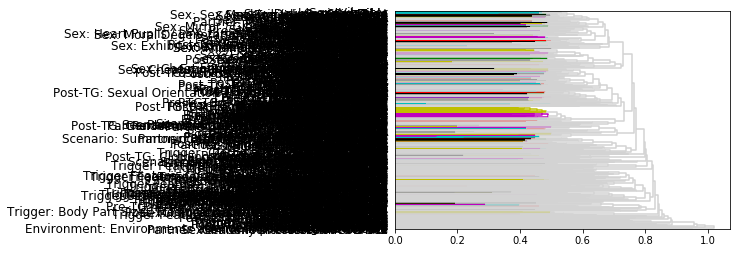

In [344]:
# au_corr.to_clipboard()
from scipy.cluster import hierarchy as hc
# import matplotlib as mpl
# from matplotlib.pyplot import cm
# cmap = cm.rainbow(np.linspace(0, 1, 150))
# hc.set_link_color_palette([mpl.colors.rgb2hex(rgb[:3]) for rgb in cmap])
# hc.set_link_color_palette(None)

# columns = [a for a in orig_df.columns if ':' in a]
columns = [a for a in orig_df.columns if ':' in a and 'Role:' not in a and 'From:' not in a and 'Media:' not in a and 'Website:' not in a and 'Gender IRL:' not in a and 'TG Fan:' not in a and 'Fandom:' not in a]
# columns = [a for a in orig_df.columns if 'Post-TG:' in a]
df = orig_df[columns]
# columns = [a for a in df.columns if 'Sex:' in a]

corr = 1 - df.corr()
corr_condensed = hc.distance.squareform(corr) # convert to condensed
z = hc.linkage(corr_condensed, method='average')
# plt.figure(figsize=(5, 200))
dendrogram = hc.dendrogram(z, labels=corr.columns, orientation='right', leaf_font_size=12, color_threshold=0.5, count_sort='ascending', above_threshold_color="lightgray")
# plt.show()


KeyboardInterrupt: 

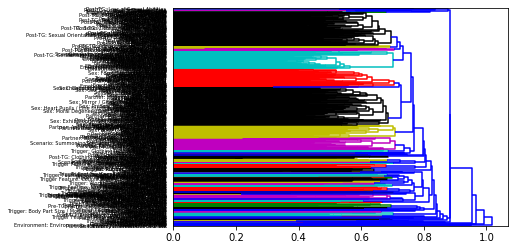

In [372]:
#!/usr/bin/python

# Load required modules
import pandas as pd 
import scipy.spatial
import scipy.cluster
import numpy as np
import json
import matplotlib.pyplot as plt
from functools import reduce

# Example data: gene expression

# # Determine distances (default is Euclidean)
# dataMatrix = np.array( df[['exp1', 'exp2']] )
# distMat = scipy.spatial.distance.pdist( dataMatrix )

# # Cluster hierarchicaly using scipy
clusters = z
T = scipy.cluster.hierarchy.to_tree( z , rd=False )

# Create dictionary for labeling nodes by their IDs
# labels = list(dendrogram['ivl'][::-1])
labels = df.columns
id2name = dict(zip(range(len(labels)), labels))

# Draw dendrogram using matplotlib to scipy-dendrogram.pdf
scipy.cluster.hierarchy.dendrogram(clusters, labels=labels, orientation='right')
plt.savefig("scipy-dendrogram.png")

# Create a nested dictionary from the ClusterNode's returned by SciPy
def add_node(node, parent ):
    # First create the new node and append it to its parent's children
    newNode = dict( node_id=node.id, children=[] )
    parent["children"].append( newNode )

    # Recursively add the current node's children
    if node.left: add_node( node.left, newNode )
    if node.right: add_node( node.right, newNode )

# Initialize nested dictionary for d3, then recursively iterate through tree
d3Dendro = dict(children=[], name="Root1")
add_node( T, d3Dendro )

# Label each node with the names of each leaf in its subtree
def label_tree( n ):
    # If the node is a leaf, then we have its name
    if len(n["children"]) == 0:
        leafNames = [ id2name[n["node_id"]] ]
    
    # If not, flatten all the leaves in the node's subtree
    else:
        leafNames = reduce(lambda ls, c: ls + label_tree(c), n["children"], [])
        print(leafNames)

    # Delete the node id since we don't need it anymore and
    # it makes for cleaner JSON
    del n["node_id"]

    # Labeling convention: "-"-separated leaf names
    # n["name"] = name = "-".join(sorted(map(str, leafNames)))
    n["name"] = "" if len(leafNames) > 1 else leafNames[0]
    
    return leafNames

label_tree( d3Dendro["children"][0] )

# Output to JSON
json.dump(d3Dendro, open("d3-dendrogram.json", "w"), sort_keys=True, indent=4)
1

Gender IRL: Female                             Gender IRL: Transgender (MtF)                    0.948404
What year did you discover an interest in TG?  What year did you begin to explore TG online?    0.910774
Pre-TG: Shaved (Face)                          Pre-TG: Shaved (Body)                            0.901239
Sex: Bound Feet                                Sex: Bound Hands                                 0.892033
Post-TG: Shaved (Genitals)                     Post-TG: Shaved (Body)                           0.873596
                                                                                                  ...   
Gender IRL: Male                               Gender IRL: Transgender (MtF)                   -0.620829
                                               Gender IRL: Female                              -0.660994
What is your age?                              What year did you discover an interest in TG?   -0.756055
                                               What yea

processing None
processing `Gender IRL: Male` == 1.0 and `Gender TG: Female` == 1.0
processing `Gender IRL: Male` == 1.0 and `Gender TG: Male` == 1.0


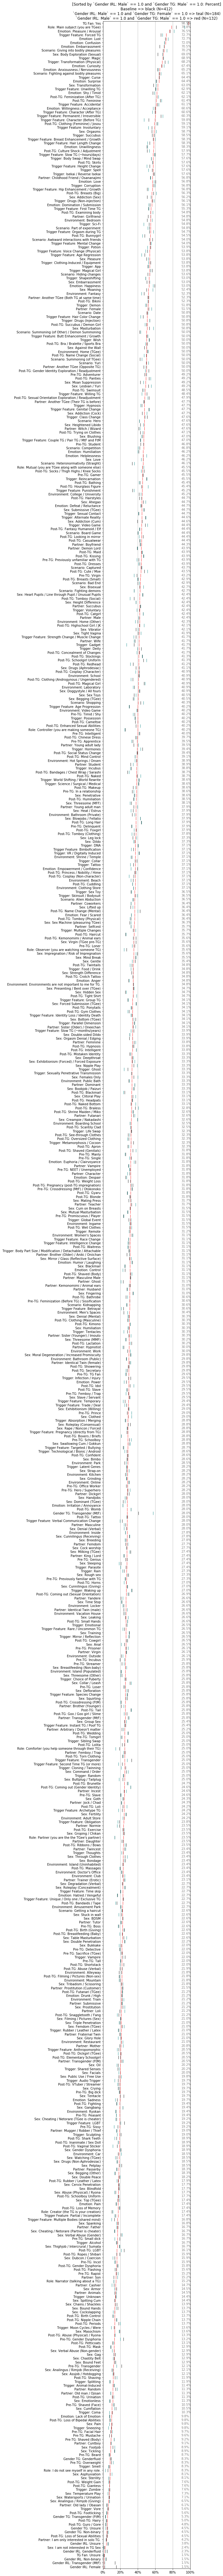

In [29]:
df = orig_df

df = df[[x for x in df.columns if ":" in x]]

def mapPercents(df, query=None):
    if query is not None:
        df = df.query(query)
    print("processing %s" % query)
    
    df = df.apply(lambda x: x.value_counts()).transpose()
    df["Total"] = df[1.0] + df[0.0]
    df["LastTrue"] = df[1.0] + df[0.0]
    df["Percent"] = df[1.0] / df["Total"] * 100
    # df = df.sort_values(by="Percent")
    df = df.drop("", errors="ignore").dropna()
    return df

# queries = [
# ]

queries = [
#     "`Role: Controller (you are making someone TG)` == 1.0",
#     "`Role: Main subject (you are TGee)` == 1.0",
    "`Gender IRL: Male` == 1.0 and `Gender TG: Female` == 1.0",
    "`Gender IRL: Male` == 1.0 and `Gender TG: Male` == 1.0",
#     "`From: 4chan` == 1.0",
#     "`From: Patreon` == 1.0",
#     "`From: E-hentai / Exhentai` == 1.0",
#     "`From: Discord` == 1.0",
]
colors = [
    "teal", # blue
    "red", # red
    "yellow", # yellow
]

columns = [x for x in df.columns if "Media:" not in x and "Fandom:" not in x and "Website:" not in x and "From:" not in x]
total_df = mapPercents(df[columns])
for i in range(len(queries)):
    tdf = mapPercents(df, queries[i])
    total_df = total_df.merge(tdf.add_prefix(queries[i] + ': '), left_index=True, right_index=True)

# select only rows we care about
# rows = [c for c in columns if 'gender' in c.lower() or 'exploration' in c.lower()]
# total_df = total_df.reindex(rows)

# targeting...
total_df['Diff'] = total_df[queries[0] + ": Percent"] - total_df[queries[1] + ": Percent"]
# total_df['Diff'] = total_df[queries[0] + ": Percent"] - total_df["Percent"]
# total_df['AbsDiff'] = abs(total_df['Diff'])
# total_df = total_df.sort_values(by='AbsDiff')

focus = queries[1] + ": Percent"
# focus = queries[0] + ": Percent"
# focus = "Diff"
# focus = "Percent"

total_df = total_df.sort_values(by=focus)

# unnecessary, since it is hidden
# total_df = total_df.query('index"Post-TG: Headpats"]')

ax = total_df.plot.barh(y="Percent", figsize=(5, 150), facecolor="None")
ax.set_title('[Sorted by %s]\nBaseline => black (N=%d)\n' % (focus, total_df['Total'].max()) + '\n'.join(['%s => %s (N=%d)' % (query, color, total_df[query + ': Total'].max()) for query, color in zip(queries, colors)]))
ax.set_xlim(0, 100)
ax.xaxis.grid()
ax.legend().set_visible(False)

i = 0
for row in total_df.iloc:
    ax.annotate("|", (row["Percent"], i), va="center", ha="center")
#     ax.annotate("{:.1%}".format(row["Diff"] / 100), (90, i), va="center", color="gray")
    ax.annotate("{:.1%}".format(row[focus] / 100), (90, i), va="center", color="gray")
    for query, color in zip(queries, colors):
        ax.annotate("|", (total_df[query + ': Percent'][row.name], i), va="center", ha="center", color=color)
    i += 1

# for p in ax.patches:
#     print(p.get_width() + p.get_height() / 2)
#     ax.annotate("|", (p.get_width(), p.get_y() + p.get_height() / 2), va="center", ha="center")
#     ax.annotate("{:.1%}".format(p.get_width() / 100), (p.get_width() * 1.005, p.get_y() + p.get_height() / 5), va="center", ha="center")

ax.xaxis.set_major_formatter(mtick.PercentFormatter())

# total_df[[focus, queries[0] + ": Percent", queries[1] + ": Percent", "Percent"]][::-1][0:50]


In [338]:
percent_columns = [c for c in total_df.select_dtypes(float).columns if 'Percent' in c or 'Total' in c or ': 1.0' in c]
# select_columns = [x for x in columns if "gender" in x.lower() or "explor" in x.lower() or "will" in x.lower()]
# percent_df = total_df[percent_columns].reindex(select_columns)
percent_df = total_df[percent_columns]
percent_df["Percent male"] = percent_df['`Gender IRL: Male` == 1.0: 1.0'] / \
    (percent_df['`Gender IRL: Transgender (MtF)` == 1.0: 1.0'] + percent_df["`Gender IRL: Male` == 1.0: 1.0"])
percent_df.sort_values(by="Percent male")['Percent male']


C:\Users\Lucky\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Gender IRL: Genderfluid                                             0.500000
Pre-TG: Transgender                                                 0.527778
Pre-TG: Gender Dysphoria                                            0.545455
Gender IRL: Non-binary                                              0.583333
Post-TG: LGBT                                                       0.605263
Trigger Feature: Transgender                                        0.615385
Trigger: Coma                                                       0.631579
Gender TG: Transgender (FtM)                                        0.636364
Post-TG: Coming out (Gender Identity)                               0.657143
Trigger Feature: LGBT                                               0.657895
Sex: Armor                                                          0.666667
Post-TG: Loss of Sexual Abilities                                   0.666667
Pre-TG: Femboy / Trap                                               0.670000

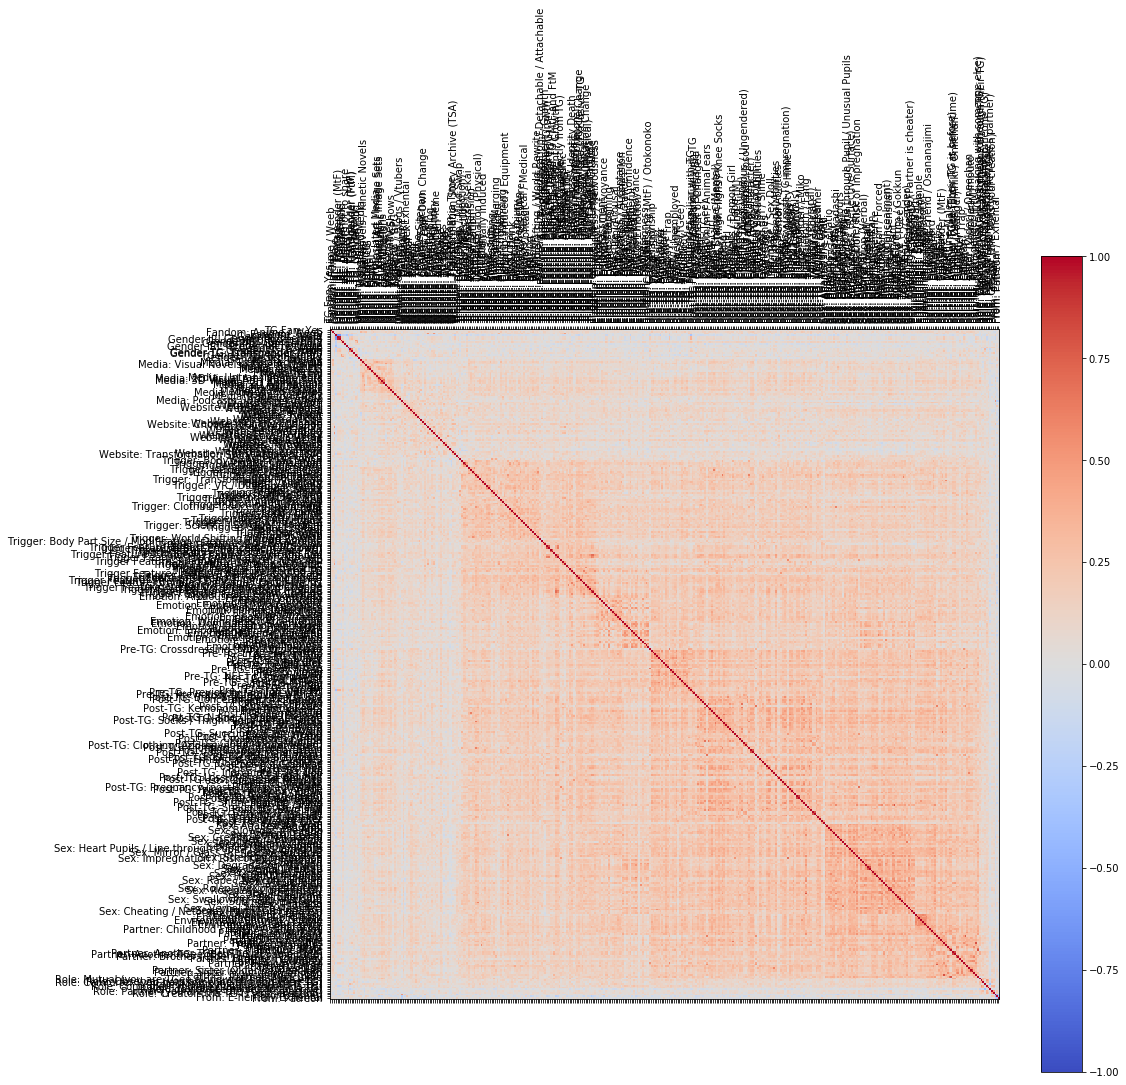

In [35]:
df = orig_df
corr = df.fillna('').corr()
# corr = corr.applymap(lambda x: x if x > 0 else 1)


data = corr
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.show()


In [37]:
# df = orig_df['What gender do you define yourself as in real life? (Check all that apply)']
df = orig_df['What gender do you define yourself regarding TG scenarios and fantasies? (Check all that apply)']

df = df.str.split(',\s*').apply(lambda x: pd.Series(1,index=x)).fillna(0).astype(bool)

df = df[["Male", "Female", "Transgender (MtF)", "Transgender (FtM)", "Non-binary", "Genderfluid", "Unsure", "Prefer not to share"]]
df["Male"] = df["Male"] | df["Transgender (FtM)"]
df["Female"] = df["Female"] | df["Transgender (MtF)"]
df = df.apply(lambda x: x.value_counts()).transpose()

df["Total"] = df[True] + df[False]
df["Percent"] = df[True] / df["Total"] * 100

# df = df[df["TotalNormalized"] > 20]

# df = df.sort_values(by="Percent")


# print(df)

# df.apply(lambda x: df[x == True])
df = df.iloc[::-1]
ax = df.plot.barh(y="Percent", figsize=(8, 5))
# ax.set_title("What gender do you define yourself as in real life?")
ax.set_title("What gender do you define yourself regarding TG scenarios and fantasies?")

ax.set_xlim(0, 100)
ax.xaxis.grid()
ax.legend().set_visible(False)

for p in ax.patches:
    ax.annotate("{:.1%}".format(p.get_width() / 100), (p.get_width() * 1.005, p.get_y() + 0.21), va="center")


KeyError: 'What gender do you define yourself regarding TG scenarios and fantasies? (Check all that apply)'

In [384]:
orig_df['Sexuality Diff'] = orig_df['Sexuality TG'] - orig_df['Sexuality IRL']
orig_df.describe()[["Sexuality IRL", "Sexuality TG", "Sexuality Diff"]]

,Sexuality IRL,Sexuality TG,Sexuality Diff
count,356.000000,329.000000,311.000000
mean,2.233146,3.401216,1.080386
std,1.493317,1.618340,1.908377
min,1.000000,1.000000,-6.000000
25%,1.000000,2.000000,0.000000
50%,2.000000,4.000000,1.000000
75%,3.000000,4.000000,2.000000
max,7.000000,7.000000,6.000000


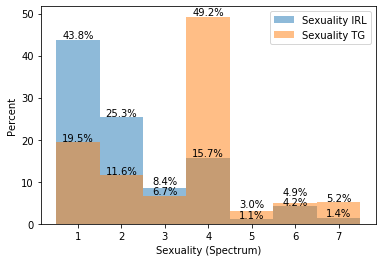

In [545]:
df = orig_df[["Sexuality IRL", "Sexuality TG"]].apply(lambda x: x.value_counts())

df["Sexuality IRL"] = df["Sexuality IRL"] / df["Sexuality IRL"].sum() * 100
df["Sexuality TG"] = df["Sexuality TG"] / df["Sexuality TG"].sum() * 100

bar1 = plt.bar(df["Sexuality IRL"].index, df["Sexuality IRL"], alpha=0.5, width=1, label="Sexuality IRL")
bar2 = plt.bar(df["Sexuality TG"].index, df["Sexuality TG"], alpha=0.5, width=1, label="Sexuality TG")

plt.legend()

ax = plt.gca()
ax.set_ylabel("Percent")
ax.set_xlabel("Sexuality (Spectrum)")

for p in bar1:
    if p.get_x() == 2.5:
        ax.annotate("{:.1f}%".format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height() + 1), ha="center")
    else:
        ax.annotate("{:.1f}%".format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height() + 0.3), ha="center")
for p in bar2:
    if p.get_x() == 4.5:
        ax.annotate("{:.1f}%".format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height() + 1), ha="center")
    elif p.get_x() == 5.5:
        ax.annotate("{:.1f}%".format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height() + 2), ha="center")
    else:
        ax.annotate("{:.1f}%".format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height() + 0.3), ha="center")
#     if p.get_height() != 0:
#         ax.annotate("{:.1f}%".format(p.get_height() / len(df) * 100), (p.get_x() + 0.5, p.get_height() + 2), ha="center")


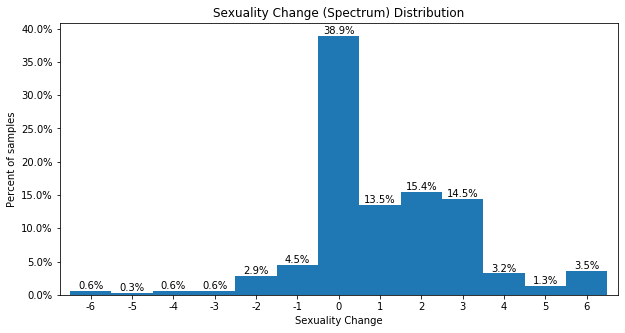

In [591]:
# AGE
df = orig_df.groupby(by=["Sexuality Diff"]).size()

mn = int(df.index.min())
mx = int(df.index.max()) + 1

df = df.reindex(np.arange(mn, mx)).fillna(0).astype(int)

df = df / df.sum() * 100
# print(df.sum())

ax = df.plot(kind="bar", figsize=(10, 5), width=1, rot=0)

ax.set_title("Sexuality Change (Spectrum) Distribution")
ax.set_ylabel("Percent of samples")
ax.set_xlabel("Sexuality Change")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

for p in ax.patches:
    if p.get_height() != 0:
        ax.annotate("{:.1f}%".format(p.get_height()), (p.get_x() + 0.5, p.get_height() + 0.3), ha="center")


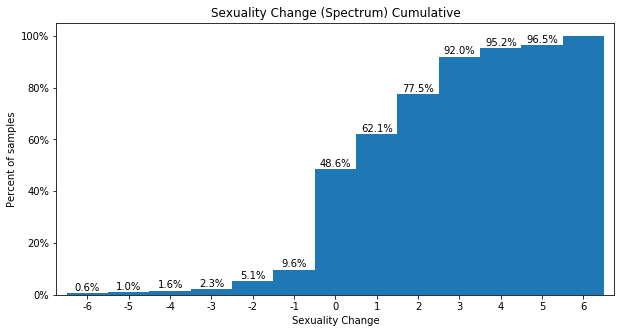

In [590]:
# AGE
df = orig_df.groupby(by=["Sexuality Diff"]).size()

mn = int(df.index.min())
mx = int(df.index.max()) + 1

df = df.reindex(np.arange(mn, mx)).fillna(0).astype(int)

df = df.cumsum() / df.sum() * 100

ax = df.plot(kind="bar", figsize=(10, 5), width=1, rot=0)

ax.set_title("Sexuality Change (Spectrum) Cumulative")
ax.set_ylabel("Percent of samples")
ax.set_xlabel("Sexuality Change")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

for p in ax.patches:
    if p.get_height() != 0 and p.get_height() != 100:
        ax.annotate("{:.1f}%".format(p.get_height()), (p.get_x() + 0.5, p.get_height() + 1), ha="center")
#         ax.annotate("{:.1f}%".format(p.get_height() / len(df) * 100), (p.get_x() + 0.5, p.get_height() + 2), ha="center")